# > C is the hyperparameter ruling the amount of regularisation in your model; see the documentation. Its inverse 1/C is called the regularisation strength in the doc. The larger C the less penalty for the parameters norm, l1 or l2. C cannot be set to 0 by the way, it has to be >0.

l1_ratio is a parameter in a [0,1] range weighting l1 vs l2 regularisation. Hence the amount of l1 regularisation is l1_ratio * 1./C, likewise the amount of l2 reg is (1-l1_ratio) * 1./C

# Step 1: Importing Libraries and Loading the Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split

In [3]:
df = pd.read_csv("Indian Liver Patient Dataset (ILPD).csv")

# Step 2: Exploratory Data Analysis (EDA)

In [7]:
df.head()

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Selector
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [9]:
# Analyze the distributions and summary statistics of the columns
df.describe()

,Age,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Selector
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,579.000000,583.000000
mean,44.746141,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064,1.286449
std,16.189833,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.319592,0.452490
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,33.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,58.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,2.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,2.000000


In [11]:
# Check the data types of the columns
df.dtypes

Age            int64
Gender        object
TB           float64
DB           float64
Alkphos        int64
Sgpt           int64
Sgot           int64
TP           float64
ALB          float64
A/G Ratio    float64
Selector       int64
dtype: object

In [13]:
# Identify missing values
df.isnull().sum()

Age          0
Gender       0
TB           0
DB           0
Alkphos      0
Sgpt         0
Sgot         0
TP           0
ALB          0
A/G Ratio    4
Selector     0
dtype: int64

# Step 3: Data Preprocessing

In [16]:
# Separate the features (X) and the target variable (y)
x = df.iloc[:,0:-1]
y = df.iloc[:,-1]

In [18]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Step 5: Model training and Evaluation

In [21]:
# Initialize the Logistic Regression model
model = LogisticRegression()

In [23]:
df.columns

Index(['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB',
       'A/G Ratio', 'Selector'],
      dtype='object')

In [25]:
# Define the columns that need imputation and encoding
numeric_features = ['Age', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB', 'A/G Ratio']
categorical_features = ['Gender']

# Create transformers for numerical and categorical features
numeric_transformer = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder()
)

# Combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Drop any remaining columns not specified
)


In [29]:
numeric_transformer

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [31]:
y_train.value_counts()

Selector
1    329
2    137
Name: count, dtype: int64

In [35]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Age', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot',
                                  'TP', 'ALB', 'A/G Ratio']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['Gender'])])

In [37]:
x_trainp=preprocessor.fit_transform(x_train)
x_testp=preprocessor.transform(x_test)

In [39]:
lr= LogisticRegression()

model=lr.fit(x_trainp,y_train)

In [41]:
# Predict on test data
y_pred = model.predict(x_testp)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



Accuracy: 0.7606837606837606


Confusion Matrix:
[[80  7]
 [21  9]]


<Axes: >

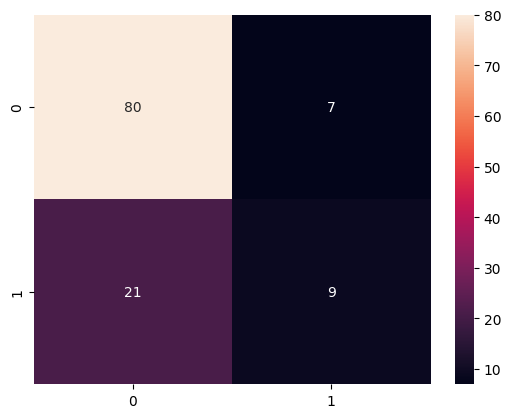

In [17]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm,annot=True)

In [18]:
# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           1       0.79      0.92      0.85        87
           2       0.56      0.30      0.39        30

    accuracy                           0.76       117
   macro avg       0.68      0.61      0.62       117
weighted avg       0.73      0.76      0.73       117



In [19]:
roc_auc_score(y_test, y_pred)

0.6097701149425288

# Step 6: Feature Importance

In [20]:
p = {
    'C': [0.1, 1.0, 10.0,20.0,30.0],
    'penalty': ['l1', 'l2','elasticnet'],
    'l1_ratio':[0.1,0.2,0.3,0.4,0.5],
    'max_iter':[100,200,300,400,500,600]
}

In [21]:
lr=LogisticRegression(solver="saga")

In [22]:

logreg_grid_search = GridSearchCV(lr, p, cv=5, return_train_score=True)


In [23]:
logreg_grid_search.fit(x_trainp,y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:

GridSearchCV(cv=5, estimator=LogisticRegression(solver='saga'),
             param_grid={'C': [0.1, 1.0, 10.0, 20.0, 30.0],
                         'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'max_iter': [100, 200, 300, 400, 500, 600],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             return_train_score=True)

l1_ratio is a parameter in a [0,1] range weighting l1 vs l2 regularisation. Hence the amount of l1 regularisation is l1_ratio * 1./C, likewise the amount of l2 reg is (1-l1_ratio) * 1./C

In [24]:
logreg_grid_search.cv_results_

{'mean_fit_time': array([0.01172996, 0.01119475, 0.01215353, 0.01217813, 0.01545796,
        0.01686339, 0.01247082, 0.01548042, 0.01670241, 0.01200161,
        0.01539884, 0.01678128, 0.01229372, 0.01553202, 0.01684852,
        0.01249676, 0.01555152, 0.01680322, 0.01072741, 0.01110477,
        0.01186795, 0.0122261 , 0.01537471, 0.01721854, 0.01148133,
        0.01576505, 0.0170505 , 0.01233721, 0.01547914, 0.01703935,
        0.01264749, 0.01544747, 0.01695938, 0.01230326, 0.01540341,
        0.01704416, 0.01081948, 0.0112762 , 0.01120338, 0.01238365,
        0.01591673, 0.01602917, 0.01200609, 0.01538806, 0.01630821,
        0.01299572, 0.01536689, 0.01609325, 0.01252093, 0.01546226,
        0.01607504, 0.01227007, 0.01586595, 0.01595902, 0.01082702,
        0.01108074, 0.01163769, 0.01228132, 0.01538553, 0.01533804,
        0.01318665, 0.01539278, 0.01515446, 0.01231475, 0.01578822,
        0.01523986, 0.0128262 , 0.01567206, 0.01503239, 0.0125618 ,
        0.01548333, 0.0149498 ,

In [25]:
logreg_grid_search.best_estimator_

LogisticRegression(C=10.0, l1_ratio=0.1, penalty='l1', solver='saga')

These values indicate the importance of each feature in predicting the target variable. Positive values indicate a positive correlation with the target, while negative values indicate a negative correlation.

In [26]:
finallr=LogisticRegression(C=10.0, l1_ratio=0.2, penalty='l1', solver='saga')
model1=finallr.fit(x_trainp,y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [27]:
# Predict on test data
y_pred = model1.predict(x_testp)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7606837606837606


Confusion Matrix:
[[80  7]
 [21  9]]


<Axes: >

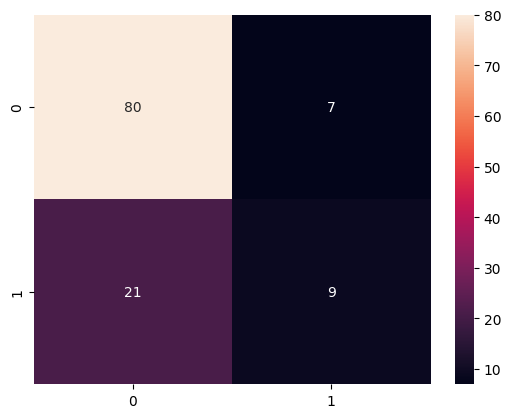

In [28]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm,annot=True)

In [29]:
# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           1       0.79      0.92      0.85        87
           2       0.56      0.30      0.39        30

    accuracy                           0.76       117
   macro avg       0.68      0.61      0.62       117
weighted avg       0.73      0.76      0.73       117



In [30]:
import seaborn as sns



In [31]:
data=sns.load_dataset("iris")

In [32]:
fv=data.iloc[:,0:-1]
cv=data.iloc[:,-1]

In [33]:
cv.value_counts()

species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

In [34]:
cv=cv.map({"setosa":0,"versicolor":1,"virginica":2})

In [35]:
lr11=LogisticRegression()
lr11.fit(fv.iloc[:,2:],cv)

LogisticRegression()

In [36]:
from mlxtend.plotting import plot_decision_regions

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


<Axes: >

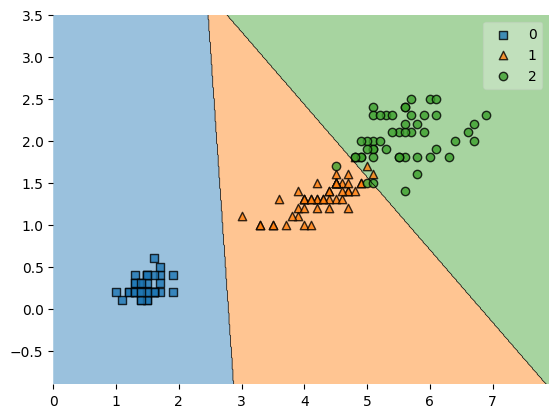

In [37]:
lr11=LogisticRegression()
lr11.fit(fv.iloc[:,2:],cv)
plot_decision_regions(X=fv.iloc[:,2:].values,y=cv.values,clf=lr11)

In [38]:
p = {
    'C': [0.1, 1.0, 10.0,20.0,30.0],
    'penalty': ['l1', 'l2','elasticnet'],
    'l1_ratio':[0.1,0.2,0.3,0.4,0.5],
    'max_iter':[100,200,300,400,500,600]
}

In [39]:
lr111=LogisticRegression(solver="saga")
lrm = GridSearchCV(lr111, p, cv=5, return_train_score=True)
lrm.fit(fv.iloc[:,2:],cv)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: Convergen

GridSearchCV(cv=5, estimator=LogisticRegression(solver='saga'),
             param_grid={'C': [0.1, 1.0, 10.0, 20.0, 30.0],
                         'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'max_iter': [100, 200, 300, 400, 500, 600],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             return_train_score=True)

In [40]:
lrm.best_params_

{'C': 0.1, 'l1_ratio': 0.1, 'max_iter': 100, 'penalty': 'l2'}

In [41]:
lrm.best_estimator_

LogisticRegression(C=0.1, l1_ratio=0.1, solver='saga')

In [42]:
fl=LogisticRegression(C=0.1, l1_ratio=0.1, solver='saga')
fl.fit(fv.iloc[:,2:],cv)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=0.1, l1_ratio=0.1, solver='saga')

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


(     petal_length  petal_width
 0             1.4          0.2
 1             1.4          0.2
 2             1.3          0.2
 3             1.5          0.2
 4             1.4          0.2
 ..            ...          ...
 145           5.2          2.3
 146           5.0          1.9
 147           5.2          2.0
 148           5.4          2.3
 149           5.1          1.8
 
 [150 rows x 2 columns],
 0      0
 1      0
 2      0
 3      0
 4      0
       ..
 145    2
 146    2
 147    2
 148    2
 149    2
 Name: species, Length: 150, dtype: int64)

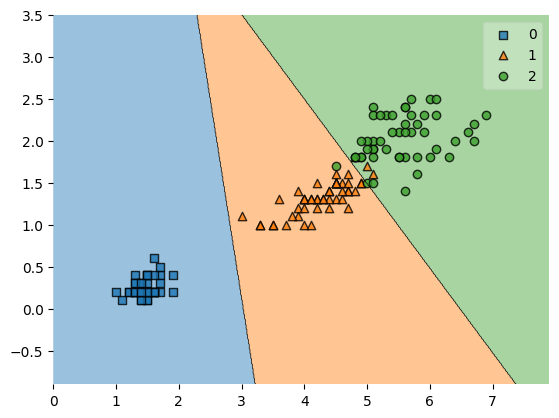

In [43]:
plot_decision_regions(X=fv.iloc[:,2:].values,y=cv.values,clf=fl)
fv.iloc[:,2:],cv

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


<Axes: >

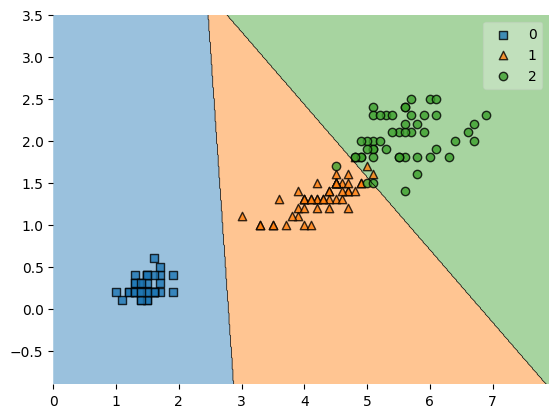

In [44]:
lr11=LogisticRegression()
lr11.fit(fv.iloc[:,2:],cv)
plot_decision_regions(X=fv.iloc[:,2:].values,y=cv.values,clf=lr11)

In [37]:
fv.iloc[:,2:]

NameError: name 'fv' is not defined